In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

# ConvNet

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [5]:
nfs = [8, 16, 32, 64, 64]

In [6]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train : [1.2607128125, tensor(0.5896, device='cuda:0')]
valid : [0.1899711669921875, tensor(0.9419, device='cuda:0')]
train : [0.19260369140625, tensor(0.9416, device='cuda:0')]
valid : [0.09994819946289063, tensor(0.9692, device='cuda:0')]
CPU times: user 4.35 s, sys: 928 ms, total: 5.28 s
Wall time: 5.31 s


# Batchnorm 

normalize then multiply by gamma and add with beta

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        # mults = gamma, adds = beta, they are parameters
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        # saves automatically
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))
        
    def update_stats(self, x):
        # get mean and var 
        # average(batches, length, width) > mean for each channel
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        # running average / exponentially weighted moving average
        # linear interpolation
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            # get mean and var first
            with torch.no_grad(): m,v = self.update_stats(x)
        # when not training, use running average
        else: m,v = self.means, self.vars
        # normalize
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [9]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [10]:
#export 
def init_cnn_(m, f):
    # zero out every bias
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    # check every layer
    for l in m.children(): init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    # kaiming init
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m,f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [11]:
#lr = 0.9
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train : [0.296338203125, tensor(0.9056, device='cuda:0')]
valid : [0.12818370361328124, tensor(0.9619, device='cuda:0')]


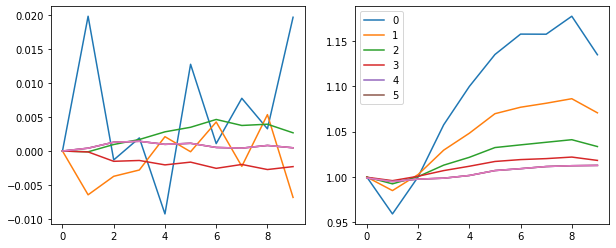

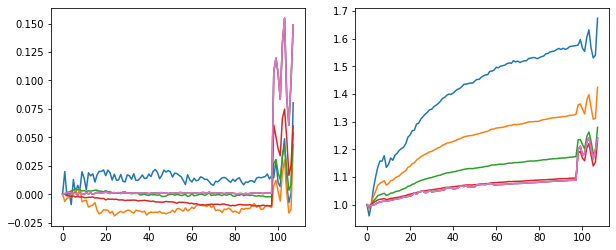

In [12]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

get rid of exponential growth and flutuation

In [13]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)
%time run.fit(3, learn)

train : [0.266460390625, tensor(0.9169, device='cuda:0')]
valid : [0.14043699951171876, tensor(0.9575, device='cuda:0')]
train : [0.08572482421875, tensor(0.9738, device='cuda:0')]
valid : [0.1782462158203125, tensor(0.9458, device='cuda:0')]
train : [0.06313470703125, tensor(0.9807, device='cuda:0')]
valid : [0.0921781982421875, tensor(0.9728, device='cuda:0')]
CPU times: user 3.6 s, sys: 651 ms, total: 4.25 s
Wall time: 4.26 s


# Builtin batchnorm

In [14]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias= not bn), 
             GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [15]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [16]:
%time run.fit(3, learn)

train : [0.29454283203125, tensor(0.9111, device='cuda:0')]
valid : [0.1196935546875, tensor(0.9633, device='cuda:0')]
train : [0.078599609375, tensor(0.9758, device='cuda:0')]
valid : [0.077737109375, tensor(0.9775, device='cuda:0')]
train : [0.054637353515625, tensor(0.9824, device='cuda:0')]
valid : [0.0653551025390625, tensor(0.9797, device='cuda:0')]
CPU times: user 3.5 s, sys: 526 ms, total: 4.03 s
Wall time: 4.03 s


# With scheduler

warm-up / annealing

In [17]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [18]:
learn, run = get_learn_run(nfs, data, 0.9, 
                           conv_layer, 
                           cbs=cbfs +[partial(ParamScheduler, 'lr', sched)])

In [19]:
run.fit(8, learn)

train : [0.3142554296875, tensor(0.9103, device='cuda:0')]
valid : [0.2295749267578125, tensor(0.9264, device='cuda:0')]
train : [0.091090478515625, tensor(0.9714, device='cuda:0')]
valid : [0.121958447265625, tensor(0.9630, device='cuda:0')]
train : [0.0692858056640625, tensor(0.9781, device='cuda:0')]
valid : [0.06428311157226563, tensor(0.9793, device='cuda:0')]
train : [0.0425510791015625, tensor(0.9869, device='cuda:0')]
valid : [0.05408426513671875, tensor(0.9832, device='cuda:0')]
train : [0.0285515478515625, tensor(0.9908, device='cuda:0')]
valid : [0.04578826293945312, tensor(0.9865, device='cuda:0')]
train : [0.01922178466796875, tensor(0.9942, device='cuda:0')]
valid : [0.04831788330078125, tensor(0.9853, device='cuda:0')]
train : [0.012556260986328125, tensor(0.9967, device='cuda:0')]
valid : [0.044817352294921876, tensor(0.9877, device='cuda:0')]
train : [0.0088266552734375, tensor(0.9981, device='cuda:0')]
valid : [0.043478924560546875, tensor(0.9878, device='cuda:0')]


# More norms

# Layer norm
batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small

The difference with BatchNorm is

1. we don't keep a moving average

2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [20]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        # average over (channel, length, width)
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var((1, 2, 3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [21]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
             GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [22]:
learn, run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [23]:
%time run.fit(3, learn)

train : [nan, tensor(0.1204, device='cuda:0')]
valid : [nan, tensor(0.0991, device='cuda:0')]
train : [nan, tensor(0.0986, device='cuda:0')]
valid : [nan, tensor(0.0991, device='cuda:0')]
train : [nan, tensor(0.0986, device='cuda:0')]
valid : [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.27 s, sys: 678 ms, total: 4.94 s
Wall time: 4.96 s


# Instance norm

key difference between contrast and batch norm is that latter applies normalization to a whole batch of images instead of single ones:

In [24]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))


    def forward(self, x):
        m = x.mean((2, 3), keepdim=True)
        v = x.var((2, 3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [25]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
             GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [26]:
learn, run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [27]:
%time run.fit(3, learn)

train : [nan, tensor(0.0986, device='cuda:0')]
valid : [nan, tensor(0.0991, device='cuda:0')]
train : [nan, tensor(0.0986, device='cuda:0')]
valid : [nan, tensor(0.0991, device='cuda:0')]
train : [nan, tensor(0.0986, device='cuda:0')]
valid : [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.28 s, sys: 696 ms, total: 4.98 s
Wall time: 4.99 s


https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl2/images/norms.png

# Group norm

From the PyTorch docs:

GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)

The input channels are separated into num_groups groups, each containing num_channels / num_groups channels. The mean and standard-deviation are calculated separately over the each group. γ
 and β
 are learnable per-channel affine transform parameter vectorss of size num_channels if affine is True.

This layer uses statistics computed from input data in both training and evaluation modes.

Args:

- num_groups (int): number of groups to separate the channels into
- num_channels (int): number of channels expected in input
- eps: a value added to the denominator for numerical stability. Default: 1e-5
- affine: a boolean value that when set to True, this module has learnable per-channel affine parameters initialized to ones (for weights) and zeros (for biases). Default: True.

Shape:

Input: (N, num_channels, *)

Output: (N, num_channels, *) (same shape as input)

Examples::

```python
input = torch.randn(20, 6, 10, 10)
# Separate 6 channels into 3 groups
m = nn.GroupNorm(3, 6)
# Separate 6 channels into 6 groups (equivalent with InstanceNorm) 
m = nn.GroupNorm(6, 6)
# Put all 6 channels into a single group (equivalent with LayerNorm)
m = nn.GroupNorm(1, 6)
# Activating the module
output = m(input)
```

# Fix small batch sizes

What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

In [28]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [29]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [30]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [31]:
%time run.fit(1, learn)

train : [2.32768921875, tensor(0.1771, device='cuda:0')]
valid : [344214.7584, tensor(0.1630, device='cuda:0')]
CPU times: user 59.3 s, sys: 658 ms, total: 60 s
Wall time: 1min


low accuracy because small batch size, one channel and one layer, variance is very small, blows up the activation

can use 0.1 as eps, so it only multiplies as 10, not 1000

# Running Batch Norm

to solve this problem, introduce a running batchnorm that uses smoother running mean and variance

In [44]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        # no of element in minibatch / channel
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        # momentum
        self.mom1 = self.dbias.new_tensor(mom1)
        # running average
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        # dbias*(1-mom) + mom
        # dbias*(1-mom)^2 + mom 
        self.dbias = self.dbias*(1-self.mom1)+self.mom1
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        # dont divide by batchsize
        # dont subtract batch mean
        # use moving average in training time
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        # batch size
        c = self.count
        # 3. debiasing make sure no observation is weighted too high
        # first point get too many weights
        # intialize sum and sqrs as zero
        
        if self.step < 100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c = c / self.dbias
        # 2. divide by exponentially moving average of batchsize
        means = sums / c
        # 1. E[X^2] - E[X]^2
        vars = (sqrs/c).sub_(means*means)
        # 4. if bs<20, var at least 0.01
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul(self.mults).add_(self.adds)
        

In [45]:
# running batchnorm
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)
    

In [46]:
learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [37]:
%time run.fit(1, learn)

train : [0.594495546875, tensor(0.8317, device='cuda:0')]
valid : [1.21184013671875, tensor(0.9198, device='cuda:0')]
CPU times: user 2min 27s, sys: 977 ms, total: 2min 28s
Wall time: 2min 29s


# What can we do in a single epoch?

In [38]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [40]:
learn, run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs+[partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [41]:
%time run.fit(1, learn)

train : [0.16124619140625, tensor(0.9510, device='cuda:0')]
valid : [0.06281268920898438, tensor(0.9814, device='cuda:0')]
CPU times: user 9.78 s, sys: 111 ms, total: 9.89 s
Wall time: 9.96 s


# Export

In [42]:
!python notebook2script.py 07_batchnorm.ipynb

Converted 07_batchnorm.ipynb to exp/nb_07.py
